In [156]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
# LightGBM is a gradient boosting framework that uses tree based learning algorithms
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    true_positive_rate, false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [157]:
# load the clean data
d = 'data/Fairlearn.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,loan_to_value_ratio,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income
0,Not Hispanic or Latino,Black or African American,Female,1,No Preapproval Requested,Converntional,Refinancing,75.00,No Interest-only Payments,No Balloon Payment,36%-<50%,Middle-Aged,Middle Class
1,Not Hispanic or Latino,Black or African American,Female,0,No Preapproval Requested,Converntional,Refinancing,52.38,No Interest-only Payments,No Balloon Payment,36%-<50%,Older,Upper-Middle Class
2,Hispanic or Latino,White,Male,0,No Preapproval Requested,Converntional,Home Purchase,80.00,No Interest-only Payments,No Balloon Payment,36%-<50%,Middle-Aged,Middle Class
3,Not Hispanic or Latino,White,Male,1,No Preapproval Requested,Converntional,Home Purchase,94.69,No Interest-only Payments,No Balloon Payment,36%-<50%,Middle-Aged,Upper-Middle Class
4,Not Hispanic or Latino,Black or African American,Male,1,Preapproval Requested,VA-guaranteed,Home Purchase,100.00,No Interest-only Payments,No Balloon Payment,50%-60%,Young,Middle Class


In [158]:
# Extract the sensitive feature - example: race
A = d["race"].apply(lambda x:1 if x == 1 else 0)
A_str = A.map({ 1:"White", 0:"Non-White"})
A_str

0        Non-White
1        Non-White
2        Non-White
3        Non-White
4        Non-White
           ...    
11143    Non-White
11144    Non-White
11145    Non-White
11146    Non-White
11147    Non-White
Name: race, Length: 11148, dtype: object

In [159]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11148 entries, 0 to 11147
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ethnicity              11148 non-null  object  
 1   race                   11148 non-null  object  
 2   gender                 11148 non-null  object  
 3   action_taken           11148 non-null  int64   
 4   preapproval_requested  11148 non-null  category
 5   loan_type              11148 non-null  category
 6   loan_purpose           11148 non-null  category
 7   loan_to_value_ratio    11148 non-null  float64 
 8   interest_only_payment  11148 non-null  category
 9   balloon_payment        11148 non-null  category
 10  debt_to_income_ratio   11148 non-null  category
 11  age                    11148 non-null  object  
 12  income                 11148 non-null  category
dtypes: category(7), float64(1), int64(1), object(4)
memory usage: 600.0+ KB


### Introduce a Synthetic Feature
loan_to_value_ratio

In [160]:
dist_scale = 0.5
np.random.seed(12345)
# Make 'loan_to_value_ratio' informative of the target to non-white clients
d['loan_to_value_ratio'] = Y + np.random.normal(scale=dist_scale, size=d.shape[0])
# But then make it uninformatiev for the white clients
d.loc[A==1, 'loan_to_value_ratio'] = np.random.normal(scale=dist_scale, size=d[A==1].shape[0])

In [161]:
d['loan_to_value_ratio'][(A==1) & (Y==0)]

Series([], Name: loan_to_value_ratio, dtype: float64)

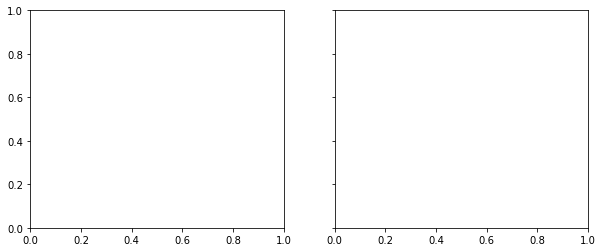

In [162]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# Plot distribution of LIMIT_BAL for white
try:
    d['loan_to_value_ratio'][(A==1) & (Y==0)].plot(kind='kde', label="Loan Denied", ax=ax1, 
                                               title="loan_to_value_ratio distribution for \"white\" group")
    d['loan_to_value_ratio'][(A==1) & (Y==1)].plot(kind='kde', label="Loan Approved", ax=ax1)
    # Plot distribution of LIMIT_BAL for women
    d['loan_to_value_ratio'][(A==0) & (Y==0)].plot(kind='kde', label="Loan Denied", ax=ax2, 
                                               legend=True, title="loan_to_value_ratio distribution for \"non-white\" group")
    d['loan_to_value_ratio'][(A==0) & (Y==1)].plot(kind='kde', label="Loan Approved", ax=ax2, 
                                               legend=True).legend(bbox_to_anchor=(1.6, 1))
except ValueError:  #raised if `y` is empty.
    pass
plt.show()

In [163]:
# Train-test split
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    d.drop(columns=['race', 'action_taken', 'ethnicity', 'gender', 'age']), 
    Y, 
    A, 
    A_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

In [164]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7803 entries, 9982 to 9796
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   preapproval_requested  7803 non-null   category
 1   loan_type              7803 non-null   category
 2   loan_purpose           7803 non-null   category
 3   loan_to_value_ratio    7803 non-null   float64 
 4   interest_only_payment  7803 non-null   category
 5   balloon_payment        7803 non-null   category
 6   debt_to_income_ratio   7803 non-null   category
 7   income                 7803 non-null   category
dtypes: category(7), float64(1)
memory usage: 176.4 KB


## Using a Fairness Unaware Model

In [165]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

In [166]:
model = lgb.LGBMClassifier(**lgb_params)

In [167]:
model.fit(df_train, Y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [168]:
# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]

In [169]:
# Train AUC
roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1])

0.9612171545478041

In [170]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

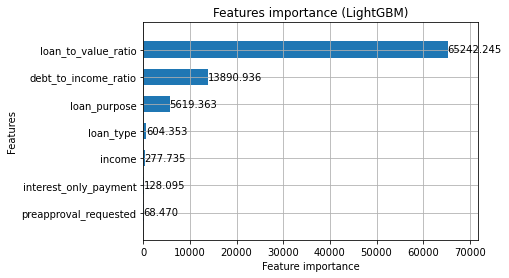

In [171]:
# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
plt.show()

We next use Fairlearn's `MetricFrame` to examine the the two different kinds of errors (false positives and false negatives) on the test data.

In [172]:
mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    Y_test, test_preds, sensitive_features=A_str_test)

mf.by_group

C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "


,FPR,FNR
race,,
Non-White,0.10401,0.101296


In [173]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        # defined by team6 - equal opportunity - the percentage of people that have rightfully benefitted from the loan model
        "True positive rate": (
            lambda x: true_positive_rate(y_true, x), True),
        # defined by team6 - equalized odds - the percentage of people that have wrongfully benefitted from the loan model
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        # defined by UCI Ex - 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.)
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

We calculate several performance and fairness metrics below:

In [174]:
# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated
Overall selection rate,0.709118
Demographic parity difference,0.0
Demographic parity ratio,1.0
------,
Overall balanced error rate,0.897347
Balanced error rate difference,0.0
------,
True positive rate,0.898704
False positive rate difference,0.0
False negative rate difference,0.0


## Mitigating Equalized Odds Difference with Postprocessing

We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [175]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)

In [176]:
# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234, replace=True).index)

In [177]:
df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

In [178]:
postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:270: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(
C:\Users\Xue Feng\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'

In [ ]:
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

In [ ]:
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, A_str_test)

## Mitigating Equalized Odds Difference with GridSearch

In [ ]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=50,
                   grid_limit=3)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

In [ ]:
sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_]

In [ ]:
equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

In [ ]:
# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

In [ ]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

In [ ]:
# Plot equalized odds difference vs AUC
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

In [ ]:
# Compare GridSearch models with low values of equalized odds difference with the previously constructed models
grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                    for i in range(len(sweep_preds))
                    if non_dominated[i] and equalized_odds_sweep[i]<0.1}
models_dict.update(grid_search_dict)
get_metrics_df(models_dict, Y_test, A_str_test)